In [84]:
# Import modules and subroutines:
include("../subroutines/Subroutines.jl");

3.10.9


In [2]:
using ConfParser
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

md_fname = "h6_sto3g_020524%1552.hdf5"

chemical_data_list = ReadIn("../datasets/pyscf_data/"*md_fname)

conf = ConfParse("../configs/pyscf_configs/h6_octahedron_sto3g.ini")
parse_conf!(conf)
bond_lengths = parse.(Float64, retrieve(conf, "GEOMETRIES", "xyz_files"));

In [3]:
# Choose a bond length:
n_x = 15
println("Radius = $(bond_lengths[n_x]) Angstrom")
chemical_data = chemical_data_list[n_x]
PrintChemData(chemical_data)

Radius = 1.2 Angstrom
Molecule name: h6
Basis set: sto3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/1.2.xyz
RHF energy: -2.4528594210037316
FCI energy: -2.798409558813491


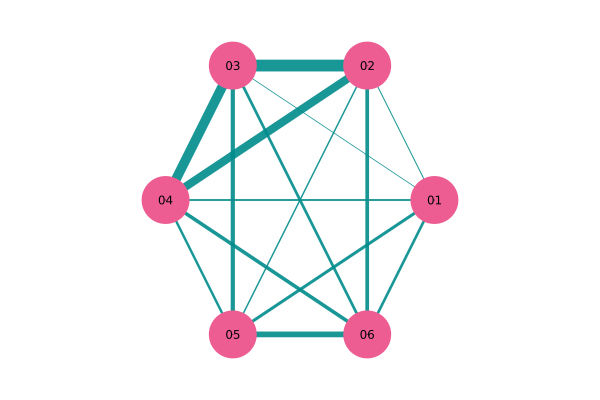

Quasi-optimal ordering: [2, 3, 4, 6, 5, 1]


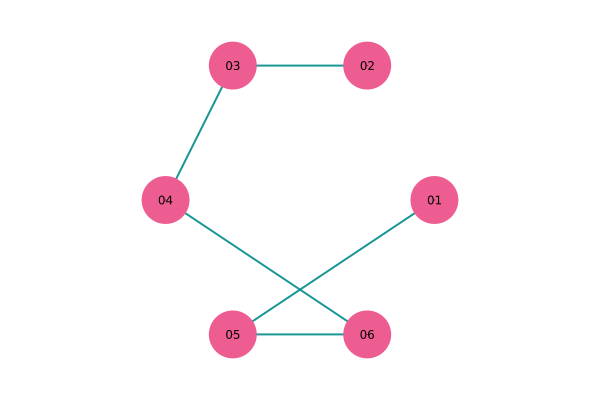

In [4]:
# Visualize the mutual information and calculate a "quasi-optimal" ordering:
fci_array = FCIArray(chemical_data)
fci_mps = MPS(fci_array, siteinds("Electron", chemical_data.N_spt), cutoff=1e-16, maxdim=2^16);

S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)
OrbitalGraphPlot(Ipq, multiplier=2e1)

gp = GeomParameters(
    maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=0.8
)

opt_ord = InfDistAnnealing(
    Ipq, 
    1, 
    gp,
    verbose=true
)[1]

println("Quasi-optimal ordering: $(opt_ord)")
OrbitalGraphPlot(GraphMat(opt_ord, directed=false), multiplier=2.0)

In [5]:
# Try a few DMRG calculations with different max. bond dimensions:

maxdims = [4,8,12,16]

#e_dmrg_list = []

"""
for n_x=1:length(bond_lengths)

    println("\n $(bond_lengths[n_x]) Angstrom [$(n_x)/$(length(bond_lengths))]: \n")
    
    fci_array = FCIArray(chemical_data_list[n_x])
    fci_mps = MPS(fci_array, siteinds("Electron", chemical_data_list[n_x].N_spt), cutoff=1e-16, maxdim=2^16);

    S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data_list[n_x])

    opt_ord = InfDistAnnealing(
        Ipq, 
        1, 
        gp,
        verbose=false
    )[1]
"""
    
e_dmrg = []

#psi_dmrg = []

for k=1:4

    dmrg_k = GenSubspace(
        chemical_data_list[n_x], 
        M=1, 
        psi_maxdim=maxdims[k], 
        init_ord = deepcopy(opt_ord),
        dflt_sweeps=Sweeps(
            20, 
            maxdim=maxdims[k], 
            noise=(1e-4,1e-6,1e-8,1e-10)
        ),
        verbose=false
    );

    push!(e_dmrg, dmrg_k.E[1])

    #push!(psi_dmrg, dmrg_k.psi_list[1])

    println("Bond dim. $(maxdims[k]): E_dmrg = $(dmrg_k.E[1]); error = $(abs(dmrg_k.E[1]+chemical_data_list[n_x].e_nuc - chemical_data_list[n_x].e_fci)); params = $(CountNonZeros(dmrg_k.psi_list))")

end
    
    #push!(e_dmrg_list, e_dmrg)
    
#end

Bond dim. 4: E_dmrg = -7.063278244280454; error = 0.13845077109219517; params = 46
Bond dim. 8: E_dmrg = -7.175698216961656; error = 0.026030798410992873; params = 91
Bond dim. 12: E_dmrg = -7.183053552638367; error = 0.018675462734282; params = 168
Bond dim. 16: E_dmrg = -7.2017290153766815; error = 4.0323300254385686e-12; params = 250


In [6]:
#CountNonZeros([psi_dmrg[3]])

In [7]:
# The optimization parameters:
op1 = OptimParameters(
    maxiter=1, 
    numloop=1,  
    thresh="projection",
    eps=1e-10,
    sd_thresh="projection", 
    sd_eps=1.0e-10,
    delta=[0.0],
    noise=[1e-5],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.999,
    sd_dtol=1e-2,
    sd_etol=0.0016,
    swap_mult=2.0
)

OptimParameters
  maxiter: Int64 1
  numloop: Int64 1
  numopt: Int64 -1
  noise: Array{Float64}((1,)) [1.0e-5]
  delta: Array{Float64}((1,)) [0.0]
  theta: Float64 0.0
  ttol: Float64 10.0
  swap_mult: Float64 2.0
  thresh: String "projection"
  eps: Float64 1.0e-10
  sd_method: String "triple_geneig"
  sd_thresh: String "projection"
  sd_eps: Float64 1.0e-10
  sd_reps: Int64 3
  sd_penalty: Float64 0.99999
  sd_swap_penalty: Float64 0.999
  sd_dtol: Float64 0.01
  sd_etol: Float64 0.0016


In [8]:
gp1 = GeomParameters(
    maxiter=30000,
    eta=-2,
    shrp=2.0,
    a_alpha=1.0
)

GeomParameters
  maxiter: Int64 30000
  afunc: String "stun"
  a_alpha: Float64 1.0
  a_gamma: Float64 100.0
  swap_mult: Float64 3.0
  a_tpow: Float64 5.0
  cweight: Float64 1.0
  eta: Int64 -2
  shrp: Float64 2.0
  anchor: Int64 0
  return_all: Bool false


In [9]:
function IpqPermute!(sdata, gp, op; no_rev=false, verbose=false)
    
    verbose && println("\nPermuting states:")
    
    for i=1:sdata.mparams.M
        
        # Compute mutual information:
        S1_i, S2_i, Ipq_i = MutualInformation(sdata.psi_list[i], sdata.ord_list[i], sdata.chem_data)

        # Compute optimal ordering:
        opt_ord_i = InfDistAnnealing(
            Ipq_i, 
            1, 
            gp,
            verbose=false
        )[1]

        # Just check the rev_flag to see if we need to reverse:
        perm_op, rev_flag = FastPMPO(sdata.sites, sdata.ord_list[i], opt_ord_i)
        if rev_flag
            reverse!(opt_ord_i)
        end
        
        GenEigPermute!(
            sdata,
            op,
            i, # State to permute
            opt_ord_i; # New ordering
            no_rev=no_rev,
            verbose=verbose
        )

    end
    
    verbose && println("\nDone!\n")
    
end

IpqPermute! (generic function with 1 method)

In [10]:
plt1 = plot(10:30, vcat([nomps1_deltavec[end]], tnqe1_deltavec), lw=2.0, label="With FSWAPs", xlabel="Optimization sweep", ylabel="Energy error (Ha.)", title="Octahedral H6; STO-3G; 1.2A; M=4, m=4")
plot!(1:30, vcat(nomps1_deltavec, tnqe2_deltavec), lw=2.0, label="No FSWAPs")
hline!([0.0], color=RGB(0.5,0.5,0.5), primary=false)
vline!([10], ls=:dash, color=RGB(0.5,0.5,0.5), primary=false)

LoadError: UndefVarError: nomps1_deltavec not defined

In [24]:
m=3

tnqe3_evec_full = []
tnqe3_evec = []

tnqe3 = GenSubspace(
    chemical_data, 
    M=1, 
    psi_maxdim=m, 
    ham_tol=1e-15,
    perm_tol=1e-15,
    thresh="projection", 
    init_ord = deepcopy(opt_ord),
    eps=1e-12, 
    sweep_num=12, 
    sweep_noise=(1e-2,1e-3,1e-4),
    dmrg_init=true,
    ovlp_opt=true,
    ovlp_weight=2.0,
    verbose=true
);

push!(tnqe3_evec, tnqe3.E[1])
push!(tnqe3_evec_full, tnqe3.E[1])

for k=1:7
    
    tnqe3 = AddStates2(
        tnqe3;
        M_new=1,
        init_ord=deepcopy(opt_ord),
        dmrg_init=false,
        ovlp_opt=true,
        ovlp_weight=2.0,
        verbose=false
    )
    
    # Permute so new states are at the front:
    perm = circshift(collect(1:tnqe3.mparams.M), 1)
    
    ShuffleStates!(tnqe3, perm=perm, no_rev=true)
    
    GenPermOps!(tnqe3)
    
    println("\n$(tnqe3.mparams.M) states:\n")

    for l=1:8

        SeedNoise!(
            tnqe3,
            0.005,
            0.0,
            jset=[1]
        )

        TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            nsite=vcat([2], [0 for i=2:tnqe3.mparams.M]),
            #nsite=[2 for i=1:tnqe3.mparams.M],
            no_swap=false,
            jperm=vcat([1], shuffle(2:tnqe3.mparams.M)),
            no_rev=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        
    end
    
    for l=1:8

        SeedNoise!(
            tnqe3,
            0.005,
            0.0
        )

        TwoSiteBlockSweep!(
            tnqe3,
            op1,
            verbose=true,
            #nsite=vcat([2,2], [0 for i=3:tnqe3.mparams.M]),
            nsite=[2 for i=1:tnqe3.mparams.M],
            no_swap=false,
            #jperm=vcat([1,2], shuffle(3:tnqe3.mparams.M)),
            no_rev=true
        )
        
        push!(tnqe3_evec_full, tnqe3.E[1])
        
    end
    
    push!(tnqe3_evec, tnqe3.E[1])
    
end



Generating Hamiltonian MPO:
Done!


Generating states:
Progress: [1/1] 
Done!

Minimum eigenvalue: -7.026591758823818
Condition number: 1.0
FCI energy: -2.798409558813491
Final energy estimate: -2.6232723022646596
Best single ref. estimate: -2.6232723022646596
Error: 0.1751372565488314
BSRfE: 0.1751372565488314
Improvement: 0.0
Percentage error reduction: 0.0
Eigenvalue condition numbers: [0.1409]
Percent correlation energy with single-geometry DMRG: 49.31639800263886
Percent correlation energy with multi-geometry TNQE: 49.31639800263886

2 states:

Loop: (1/1); Bond: 5/5; #swaps: 3; E_min = -7.06471; Delta = 0.13702; kappa_full = 1.26; kappa = 1.1      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.06604; Delta = 0.13569; kappa_full = 1.32; kappa = 1.13     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.0661; Delta = 0.13563; kappa_full = 1.38; kappa = 1.16      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.06611; Delta = 0.13562; kappa_full = 1.43; kappa = 1.18

In [25]:
m=3

nomps3_evec_full = []
nomps3_evec = []

nomps3 = GenSubspace(
    chemical_data, 
    M=1, 
    psi_maxdim=m, 
    ham_tol=1e-15,
    perm_tol=1e-15,
    thresh="projection", 
    init_ord = deepcopy(opt_ord),
    eps=1e-12, 
    sweep_num=12, 
    sweep_noise=(1e-2,1e-3,1e-4),
    dmrg_init=true,
    ovlp_opt=true,
    ovlp_weight=2.0,
    verbose=true
);

push!(nomps3_evec, nomps3.E[1])
push!(nomps3_evec_full, nomps3.E[1])

for k=1:7
    
    nomps3 = AddStates2(
        nomps3;
        M_new=1,
        init_ord=deepcopy(opt_ord),
        dmrg_init=false,
        ovlp_opt=true,
        ovlp_weight=2.0,
        verbose=false
    )
    
    # Permute so new states are at the front:
    perm = circshift(collect(1:nomps3.mparams.M), 1)
    
    ShuffleStates!(nomps3, perm=perm, no_rev=true)
    
    GenPermOps!(nomps3)
    
    println("\n$(nomps3.mparams.M) states:\n")

    for l=1:8

        SeedNoise!(
            nomps3,
            0.01,
            0.0,
            jset=[1]
        )

        TwoSiteBlockSweep!(
            nomps3,
            op1,
            verbose=true,
            nsite=vcat([2], [0 for i=2:nomps3.mparams.M]),
            #nsite=[2 for i=1:nomps3.mparams.M],
            no_swap=true,
            jperm=vcat([1], shuffle(2:nomps3.mparams.M)),
            no_rev=true
        )
        
        push!(nomps3_evec_full, nomps3.E[1])
        
    end
    
    for l=1:8

        SeedNoise!(
            nomps3,
            0.01,
            0.0
        )

        TwoSiteBlockSweep!(
            nomps3,
            op1,
            verbose=true,
            #nsite=vcat([2,2], [0 for i=3:nomps3.mparams.M]),
            nsite=[2 for i=1:nomps3.mparams.M],
            no_swap=true,
            #jperm=vcat([1,2], shuffle(3:nomps3.mparams.M)),
            no_rev=true
        )
        
        push!(nomps3_evec_full, nomps3.E[1])
        
    end
    
    push!(nomps3_evec, nomps3.E[1])
    
end


Generating Hamiltonian MPO:
Done!


Generating states:
Progress: [1/1] 
Done!

Minimum eigenvalue: -7.024565340945907
Condition number: 1.0
FCI energy: -2.798409558813491
Final energy estimate: -2.6212458843867488
Best single ref. estimate: -2.6212458843867488
Error: 0.1771636744267422
BSRfE: 0.1771636744267422
Improvement: 0.0
Percentage error reduction: 0.0
Eigenvalue condition numbers: [0.1409]
Percent correlation energy with single-geometry DMRG: 48.7299656282358
Percent correlation energy with multi-geometry TNQE: 48.7299656282358

2 states:

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.03234; Delta = 0.16939; kappa_full = 17.9; kappa = 1.34     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.06442; Delta = 0.13731; kappa_full = 3.92; kappa = 1.66     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.06587; Delta = 0.13586; kappa_full = 2.09; kappa = 1.59     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.06587; Delta = 0.13586; kappa_full = 2.09; kappa = 1.59  

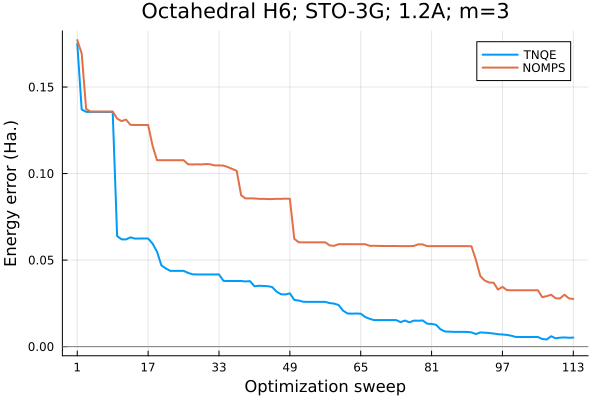

In [68]:
xvals = 1:length(tnqe3_evec_full)

yvals1 = tnqe3_evec_full .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
yvals2 = nomps3_evec_full .+ (nomps3.chem_data.e_nuc - nomps3.chem_data.e_fci)

vx = collect(0:7).*16 .+ 1

plt1 = plot(
    xvals, 
    yvals1,  
    lw=2.0, 
    label="TNQE", 
    xlabel="Optimization sweep", 
    ylabel="Energy error (Ha.)", 
    title="Octahedral H6; STO-3G; 1.2A; m=3", 
    xticks=vx,
    gridlinewidth=1.0,
    gridalpha=0.1
)

plot!(
    xvals, 
    yvals2, 
    lw=2.0, 
    label="NOMPS"
)

hline!([0.0], color=RGB(0.5,0.5,0.5), primary=false)
#vline!(vx, ls=:dash, lw=0.6, color=RGB(0.5,0.5,0.5), primary=false)

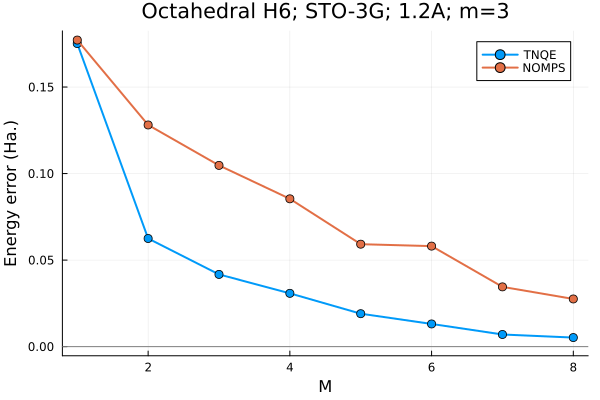

In [47]:
xvals = 1:length(tnqe3_evec)

yvals1 = tnqe3_evec .+ (tnqe3.chem_data.e_nuc - tnqe3.chem_data.e_fci)
yvals2 = nomps3_evec .+ (nomps3.chem_data.e_nuc - nomps3.chem_data.e_fci)

plt1 = plot(
    xvals, 
    yvals1, 
    markershape=:circle, 
    markersize=4.5, 
    lw=2.0, 
    label="TNQE", 
    xlabel="M", 
    ylabel="Energy error (Ha.)", 
    title="Octahedral H6; STO-3G; 1.2A; m=3"
)

plot!(xvals, yvals2, markershape=:circle, markersize=4.5, lw=2.0, label="NOMPS")
hline!([0.0], color=RGB(0.5,0.5,0.5), primary=false)
#vline!([10], ls=:dash, color=RGB(0.5,0.5,0.5), primary=false)

In [77]:
sumps = SumMPS(nomps3, final_ord=nomps3.ord_list[1]);
truncate!(sumps, cutoff=1e-5);
println(linkdims(sumps))
println(inner(sumps', nomps3.ham_list[1], sumps)+nomps3.chem_data.e_nuc-nomps3.chem_data.e_fci)
CountNonZeros(nomps3.psi_list)

[4, 12, 14, 11, 4]
0.02759319518025194


262

In [78]:
sumps = SumMPS(tnqe3, final_ord=tnqe3.ord_list[1]);
truncate!(sumps, cutoff=1e-5);
println(linkdims(sumps))
println(inner(sumps', tnqe3.ham_list[1], sumps)+tnqe3.chem_data.e_nuc-tnqe3.chem_data.e_fci)
CountNonZeros(tnqe3.psi_list)

[4, 16, 18, 16, 4]
0.005256270508905203


230

In [85]:
PrintFSWAPNetworks!(tnqe3)



###### 1-2 ######
Max. linkdim = 16

2-----2
       
4-----4
       
3-----3
       
6---x-5
    |  
1-x-x-6
  |    
5-x---1


###### 1-3 ######
Max. linkdim = 16

2-x---x-3
  |   |  
4-x-x-x-4
    |    
3---x---2
         
6-------6
         
1-x-----5
  |      
5-x-----1


###### 1-4 ######
Max. linkdim = 16

2-x---x-3
  |   |  
4-x-x-x-4
    |    
3---x---2
         
6-x-----1
  |      
1-x-x---5
    |    
5---x---6


###### 1-5 ######
Max. linkdim = 16

2-----2
       
4-x---3
  |    
3-x-x-6
    |  
6---x-4
       
1-x---5
  |    
5-x---1


###### 1-6 ######
Max. linkdim = 16

2-x---x-3
  |   |  
4-x-x-x-4
    |    
3---x---2
         
6-------6
         
1-x-----5
  |      
5-x-----1


###### 1-7 ######
Max. linkdim = 16

2-----2
       
4-x---3
  |    
3-x---4
       
6---x-5
    |  
1-x-x-6
  |    
5-x---1


###### 1-8 ######
Max. linkdim = 16

2---x-3
    |  
4-x-x-2
  |    
3-x---4
       
6-----6
       
1-x---5
  |    
5-x---1


###### 2-3 ######
Max. linkdim = 16

2-x---